# Regression model
## Standard imports

First, setup some standard modules and matplotlib.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

Load the main `sciapy` module and its wrappers for easy access to the used proxy timeseries.

In [2]:
import sciapy
from sciapy.regress.load_data import load_dailymeanAE, load_dailymeanLya

## Model interface

We set some fixed parameters to scale the data and for the parameter bounds.

In [3]:
data_scale = 1e-6  # The data were scaled by 10^-6 before fitting
max_days = 100
max_amp = 1e10 * data_scale  # bounds for fitting, actually not used here

## Individual model parts

The model is set up part by part, beginning with the more involved proxy models.

### Lyman-$\alpha$ proxy

The Lyman-$\alpha$ proxy is not centered (mean-subtracted),
and its coefficient (`amp` for "amplitude") can take
positive and negative values (cf. `bounds["amp"]`).

In [21]:
# load proxy data
plat, plap = load_dailymeanLya()
# setup the model
lya_mod = sciapy.regress.ProxyModel(plat,
                                    plap["Lya"],
                                    center=False,
                                    amp=0,
                                    lag=0,
                                    tau0=0,
                                    taucos1=0, tausin1=0,
                                    taucos2=0, tausin2=0,
                                    ltscan=60,
                                    bounds={"amp": [-max_amp, max_amp],
                                            "lag": [0, max_days],
                                            "tau0": [0, max_days],
                                            "taucos1": [-max_days, max_days],
                                            "tausin1": [-max_days, max_days],
                                            # semi-annual cycles for the life time
                                            "taucos2": [-max_days, max_days],
                                            "tausin2": [-max_days, max_days],
                                            "ltscan": [0, 200]})

### AE proxy with lifetime

The AE proxy is also not centered, but its coefficient (`amp`) can only take positive values (cf. `bounds["amp"]`).

In [5]:
# load proxy data
paet, paep = load_dailymeanAE()
# setup the model
ae_mod = sciapy.regress.ProxyModel(paet,
                                   paep["AE"],
                                   center=False,
                                   amp=0,
                                   lag=0,
                                   tau0=0,
                                   taucos1=0, tausin1=0,
                                   taucos2=0, tausin2=0,
                                   ltscan=60,
                                   bounds={"amp": [0, max_amp],
                                           "lag": [0, max_days],
                                           "tau0": [0, max_days],
                                           "taucos1": [-max_days, max_days],
                                           "tausin1": [-max_days, max_days],
                                           # semi-annual cycles for the life time
                                           "taucos2": [-max_days, max_days],
                                           "tausin2": [-max_days, max_days],
                                           "ltscan": [0, 200]})

### Offset

In [6]:
offset_model = sciapy.regress.ConstantModel(value=0.,
                                            bounds={"value": [-max_amp, max_amp]})

### Optional harmonic terms

The harmonic terms are not used here but we include them to show how to set them up.

In [7]:
harm1 = sciapy.regress.HarmonicModelCosineSine(freq=1, cos=0, sin=0,
                                bounds={"cos": [-max_amp, max_amp], "sin": [-max_amp, max_amp]})
harm2 = sciapy.regress.HarmonicModelCosineSine(freq=2, cos=0, sin=0,
                                bounds={"cos": [-max_amp, max_amp], "sin": [-max_amp, max_amp]})

# frequencies should not be fitted
harm1.freeze_parameter("freq")
harm2.freeze_parameter("freq")

## Combined model

In [8]:
no_mod = sciapy.regress.CeleriteModelSet([("offset", offset_model),
                                          ("Lya", lya_mod), ("GM", ae_mod),
                                          ("f1", harm1), ("f2", harm2)])

The full model has the following parameters:

In [9]:
no_mod.get_parameter_dict()

OrderedDict([('offset:value', 0.0),
             ('Lya:amp', 0.0),
             ('Lya:lag', 0.0),
             ('Lya:tau0', 0.0),
             ('Lya:taucos1', 0.0),
             ('Lya:tausin1', 0.0),
             ('Lya:taucos2', 0.0),
             ('Lya:tausin2', 0.0),
             ('Lya:ltscan', 60.0),
             ('GM:amp', 0.0),
             ('GM:lag', 0.0),
             ('GM:tau0', 0.0),
             ('GM:taucos1', 0.0),
             ('GM:tausin1', 0.0),
             ('GM:taucos2', 0.0),
             ('GM:tausin2', 0.0),
             ('GM:ltscan', 60.0),
             ('f1:cos', 0.0),
             ('f1:sin', 0.0),
             ('f2:cos', 0.0),
             ('f2:sin', 0.0)])

But we don't need all of them, so we freeze all parameters and thaw the ones we need.
This is easier than the other way around (freezing all unused parameters).

In [10]:
no_mod.freeze_all_parameters()
no_mod.thaw_parameter("offset:value")
no_mod.thaw_parameter("Lya:amp")
no_mod.thaw_parameter("GM:amp")
no_mod.thaw_parameter("GM:tau0")
no_mod.thaw_parameter("GM:taucos1")
no_mod.thaw_parameter("GM:tausin1")

Cross check that only the used parameters are really active:

In [11]:
no_mod.get_parameter_dict()

OrderedDict([('offset:value', 0.0),
             ('Lya:amp', 0.0),
             ('GM:amp', 0.0),
             ('GM:tau0', 0.0),
             ('GM:taucos1', 0.0),
             ('GM:tausin1', 0.0)])

## Model parameters

In this tutorial, we use the already fitted model parameters. The data file we take them from contains the median together with the (0.16, 0.84), (0.025, 0.975), and (0.001, 0.999) quantiles corresponding to the 1$\sigma$, 2$\sigma$, and 3$\sigma$ confidence regions.

In [12]:
quants_nl = xr.open_dataset("NO_regress_quantiles_pGM_Lya_ltcs_exp1dscan60d_km32.nc",
                            decode_cf=False)

The contents of the quantiles dataset are:

In [13]:
quants_nl

<xarray.Dataset>
Dimensions:            (alt: 16, lat: 18, quantile: 7)
Coordinates:
  * alt                (alt) float64 60.0 62.0 64.0 66.0 68.0 70.0 72.0 74.0 ...
  * lat                (lat) float64 -85.0 -75.0 -65.0 -55.0 -45.0 -35.0 ...
  * quantile           (quantile) float64 0.001 0.025 0.16 0.5 0.84 0.975 0.999
Data variables:
    kernel:log_rho     (lat, alt, quantile) float64 ...
    kernel:log_sigma   (lat, alt, quantile) float64 ...
    mean:GM:amp        (lat, alt, quantile) float64 ...
    mean:GM:tau0       (lat, alt, quantile) float64 ...
    mean:GM:taucos1    (lat, alt, quantile) float64 ...
    mean:GM:tausin1    (lat, alt, quantile) float64 ...
    mean:Lya:amp       (lat, alt, quantile) float64 ...
    mean:offset:value  (lat, alt, quantile) float64 ...

And the dimensions of the available parameters are:

In [14]:
quants_nl.lat, quants_nl.alt

(<xarray.DataArray 'lat' (lat: 18)>
 array([-85., -75., -65., -55., -45., -35., -25., -15.,  -5.,   5.,  15.,  25.,
         35.,  45.,  55.,  65.,  75.,  85.])
 Coordinates:
   * lat      (lat) float64 -85.0 -75.0 -65.0 -55.0 -45.0 -35.0 -25.0 -15.0 ...
 Attributes:
     _FillValue:  nan
     long_name:   latitude
     units:       degrees_north, <xarray.DataArray 'alt' (alt: 16)>
 array([60., 62., 64., 66., 68., 70., 72., 74., 76., 78., 80., 82., 84., 86.,
        88., 90.])
 Coordinates:
   * alt      (alt) float64 60.0 62.0 64.0 66.0 68.0 70.0 72.0 74.0 76.0 78.0 ...
 Attributes:
     _FillValue:  nan
     long_name:   altitude
     units:       km)

Loop over the parameter names and set them to the median values for the selected altitude and latitude bin.
The variables in the quantiles file were created using [celerite](https://github.com/dfm/celerite)
which prepends "mean:" to the variables from the mean model.

In [15]:
# select latitude and altitude first
latitude = 65
altitude = 70

for v in no_mod.get_parameter_names():
    no_mod.set_parameter(v, quants_nl["mean:{0}".format(v)].sel(alt=altitude, lat=latitude, quantile=0.5))

The mean model parameters are now set to the following:

In [16]:
no_mod.get_parameter_dict()

OrderedDict([('offset:value', -25.577781189820513),
             ('Lya:amp', 6.259250259251973),
             ('GM:amp', 0.08741185118056463),
             ('GM:tau0', 1.5387433096984084),
             ('GM:taucos1', 10.520064600296648),
             ('GM:tausin1', -0.7141699243523804)])

With the parameters properly set, we can now "predict" the density for any time we wish.
Here we take 15 years daily:

In [19]:
times = np.arange(1992, 2017.01, 0.5 / 365.25)
pred_no = no_mod.get_value(times)

and then plot the result:

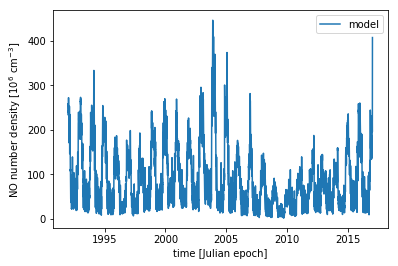

In [20]:
plt.plot(times, pred_no, label="model")
plt.xlabel("time [Julian epoch]")
plt.ylabel("NO number density [10$^{{{0:.0f}}}$ cm$^{{-3}}$]".format(-np.log10(data_scale)))
plt.legend();